In this example we are loading json data from an API called ReelTrouble which we made in a previous semester. The data comes from TMDB which is an international database for movies.

In [1]:
from Read.readfile.jsonio import pd, read_json, encoding_json_utf8

package imported


In [2]:
# Load JSON with utf-8

data = encoding_json_utf8("reeltrouble.json")

In [3]:
# Ingestion
# Convert to DataFrame
df = pd.DataFrame(data)

In [4]:
# Explore
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           279 non-null    int64  
 1   movieApiId   279 non-null    int64  
 2   title        279 non-null    object 
 3   description  279 non-null    object 
 4   imdbRating   279 non-null    float64
 5   releaseDate  279 non-null    object 
 6   minutes      279 non-null    int64  
 7   actors       279 non-null    object 
 8   directors    279 non-null    object 
 9   genres       279 non-null    object 
dtypes: float64(1), int64(3), object(6)
memory usage: 21.9+ KB
None


In [7]:
# Pretty-print first movie
print(json.dumps(data[0], indent=2, ensure_ascii=False))

{
  "id": 1,
  "movieApiId": 822119,
  "title": "Captain America: Brave New World",
  "description": "After meeting with newly elected U.S. President Thaddeus Ross, Sam finds himself in the middle of an international incident. He must discover the reason behind a nefarious global plot before the true mastermind has the entire world seeing red.",
  "imdbRating": 6.1,
  "releaseDate": [
    2025,
    2,
    12
  ],
  "minutes": 119,
  "actors": [
    {
      "name": "Travis Powers",
      "id": 3867541
    },
    {
      "name": "Giancarlo Esposito",
      "id": 4808
    },
    {
      "name": "William Mark McCullough",
      "id": 1498700
    },
    {
      "name": "Cris Ruiz",
      "id": 2680749
    },
    {
      "name": "Gabriela Amarchand",
      "id": 2761607
    },
    {
      "name": "Hector Banos",
      "id": 2232794
    },
    {
      "name": "Liv Tyler",
      "id": 882
    },
    {
      "name": "Ben Vazquez",
      "id": 2170784
    },
    {
      "name": "Xosha Roquemore"

The data is a list of json objects for movies, where actors is a list inside each movie. We will then expand actors into its own dataframe.

In [9]:
# Cleaning
# Expand actors
actors_df = df[['id', 'actors']].explode('actors')

# Expand the actors dict into columns
actors_expanded = actors_df['actors'].apply(pd.Series)

# Rename the columns to clarify
actors_expanded = actors_expanded.rename(columns={'id': 'actor_id', 'name': 'actor_name'})

# Combine with movie id
actors_df = pd.concat([actors_df.drop(columns=['actors']), actors_expanded], axis=1)


In [21]:
# Count how many movies each actor appears in
actor_counts = actors_df.groupby(['actor_id', 'actor_name'])['id'].nunique().reset_index(name='movie_count')

# Filter actors who appear in more than one movie
repeated_actors = actor_counts[actor_counts['movie_count'] > 1]

# Filter actors who only appear in one movie
non_repeated_actors = actor_counts[actor_counts['movie_count'] == 1]

print(repeated_actors)
print('Actors that only appear in 1 movie:', len(non_repeated_actors))
print('Total amount of actors:', len(non_repeated_actors)+len(repeated_actors))

      actor_id            actor_name  movie_count
0            2           Mark Hamill            2
8           53        Peter Stormare            2
9           63        Milla Jovovich            2
13         112        Cate Blanchett            2
17         140              Lucy Liu            3
...        ...                   ...          ...
7889   5153550            Yves Cueni            2
7893   5153559       Jonathan Bourne            2
8033   5217381           Ben Blevins            2
8104   5234074  Batanai Mashingaidze            2
8435   5333275             Will Fitz            2

[727 rows x 3 columns]
Actors that only appear in 1 movie: 7834
Total amount of actors 8561


In [8]:
# Anonymisation
# TODO: Try using faker library instead
# hide actor/director names
import hashlib

def anonymize_name(name: str) -> str:
    """Return anonymized version of a name using hashing."""
    return hashlib.sha256(name.encode()).hexdigest()[:10]  # shorten hash

# Apply to actors
actors_df['anon_name'] = actors_df['name'].apply(anonymize_name)

# Apply to directors
directors_df['anon_name'] = directors_df['name'].apply(anonymize_name)


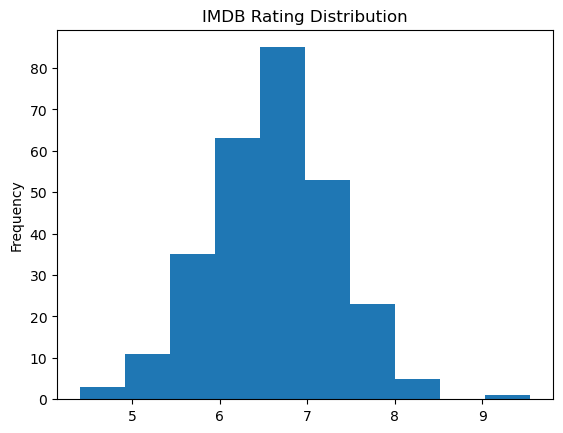

In [10]:
# Visualisation
import matplotlib.pyplot as plt

# Example 1: Distribution of IMDB ratings
df['imdbRating'].plot(kind='hist', bins=10, title="IMDB Rating Distribution")
plt.show()


This graph shows the distribution of IMDB ratings for all the movies. The ReelTrouble API only works with movies over a certain rating (I think it was 2). Therefor there aren't any low rated movies displayed in the graph.

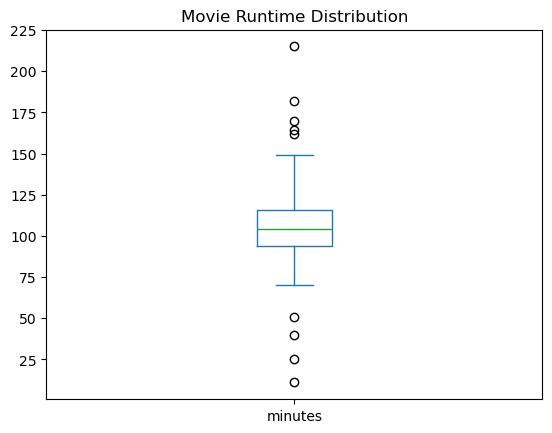

In [11]:
# Example 2: Movie lengths
df['minutes'].plot(kind='box', title="Movie Runtime Distribution")
plt.show()

The Boxplot graph illustrates the runtime of the movies in minutes, the white dots are outliers. ReelTrouble has a few shortfilms which can explain the outliers at the bottom.

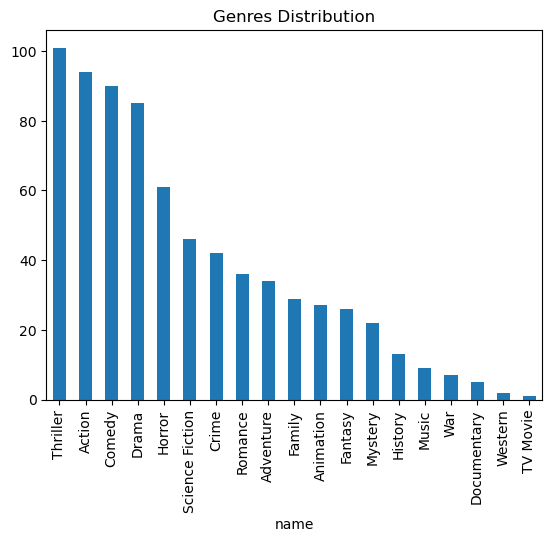

In [12]:
# Example 3: Count of genres
all_genres = df['genres'].explode().dropna()
genre_counts = pd.DataFrame(all_genres.tolist())['name'].value_counts()

genre_counts.plot(kind='bar', title="Genres Distribution")
plt.show()

This graph shows the distribution of different genres. ReelTrouble only has movies from the last year.